In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 13.5MB/s 
     |████████████████████████████████| 3.0MB 13.9MB/s 
     |████████████████████████████████| 890kB 38.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=849bbc7d84c5d572b920f16f24c16c7e35ea54359c6db0b16db24fd408c54064
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving messages.csv to messages.csv


In [ ]:
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['messages.csv']))
# Dataset is now stored in a Pandas Dataframe
df.head()

,message_id,response_id,article_id,empathy,distress,empathy_bin,distress_bin,essay
0,R_1hGrPtWM4SumG0U_1,R_1hGrPtWM4SumG0U,67,5.667,4.375,1,1,it is really diheartening to read about these ...
1,R_1hGrPtWM4SumG0U_2,R_1hGrPtWM4SumG0U,86,4.833,4.875,1,1,the phone lines from the suicide prevention li...
2,R_1hGrPtWM4SumG0U_3,R_1hGrPtWM4SumG0U,206,5.333,3.500,1,0,"no matter what your heritage, you should be ab..."
3,R_1hGrPtWM4SumG0U_4,R_1hGrPtWM4SumG0U,290,4.167,5.250,1,1,it is frightening to learn about all these sha...
4,R_1hGrPtWM4SumG0U_5,R_1hGrPtWM4SumG0U,342,5.333,4.625,1,1,the eldest generation of russians aren't being...


In [ ]:
df = df[['essay', 'empathy', 'empathy_bin']]

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df, random_state=103).reset_index(drop=True)
df.head()

,essay,empathy,empathy_bin
0,I can't really believe he was found dead in ol...,3.500,0
1,This is just disgusting. I cannot believe that...,1.000,0
2,I just read a story about a study being done b...,7.000,1
3,GBR The great barrier reef. I read an article ...,6.500,1
4,There was another gunman attacking random peop...,4.333,1


In [ ]:
train = df[:1760]
test = df[1760:]
print(train.shape)
print(test.shape)

(1760, 3)
(100, 3)


In [ ]:
train.groupby('empathy_bin').size()

empathy_bin
0    894
1    866
dtype: int64

In [ ]:
test.groupby('empathy_bin').size()

empathy_bin
0    50
1    50
dtype: int64

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Loading BERT tokenizer...


In [ ]:
import numpy as np

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# Record the length of each sequence (after truncating to 512).
lengths = []

print('Tokenizing comments...')

# For every sentence...
for sen in train.essay:
    
    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

    # Record the truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')
print('{:>10,} comments'.format(len(input_ids)))

Tokenizing comments...
  Read 0 comments.
DONE.
     1,760 comments


In [ ]:
# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
labels = train.empathy_bin.to_numpy().astype(int)

print('{:>7,} empathetic'.format(np.sum(labels)))
print('{:>7,} not empathetic'.format(len(labels) - np.sum(labels)))

    866 empathetic
    894 not empathetic


In [ ]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 57 tokens
   Max length: 201 tokens
Median length: 88.0 tokens


In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the required sequence length.
MAX_LEN = 256

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 256 values...

Padding token: "[PAD]", ID: 0

Done.


Using TensorFlow backend.


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 12

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #b_input_ids = batch[0]
        #b_input_mask = batch[1]
        #b_labels = batch[2]

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        #batch = tuple(t for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 12 ========
Training...

  Average training loss: 0.68
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.60
  Validation took: 0:00:05

======== Epoch 2 / 12 ========
Training...

  Average training loss: 0.59
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.63
  Validation took: 0:00:05

======== Epoch 3 / 12 ========
Training...

  Average training loss: 0.47
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.64
  Validation took: 0:00:05

======== Epoch 4 / 12 ========
Training...

  Average training loss: 0.33
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.62
  Validation took: 0:00:05

======== Epoch 5 / 12 ========
Training...

  Average training loss: 0.22
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.62
  Validation took: 0:00:05

======== Epoch 6 / 12 ========
Training...

  Average training loss: 0.12
  Training epcoh took: 0:01:58

Running Validation...
  Accu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


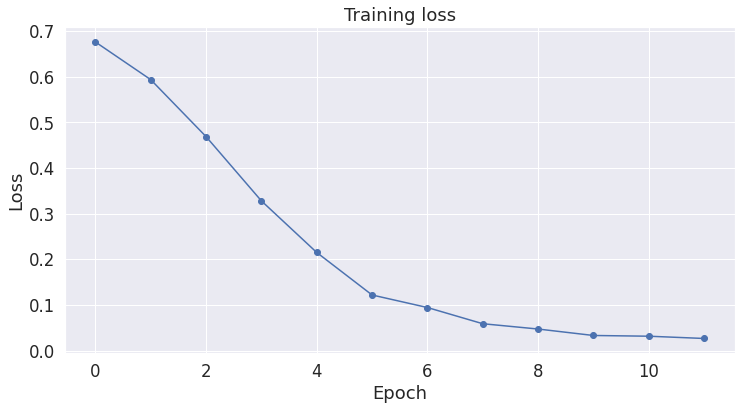

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sen in test.essay:
    
    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,          # Truncate all sentences.                        
                   )
    
    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_sent)

print('DONE.')
print('')
print('{:>10,} test comments'.format(len(test_input_ids)))

# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
test_labels = test.empathy_bin.to_numpy().astype(int)

print('{:>10,} empethatic'.format(np.sum(test_labels)))
print('{:>10,} not empetgatic'.format(len(test_labels) - np.sum(test_labels)))

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                               dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask) 

# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

DONE.

       100 test comments
        50 empethatic
        50 not empetgatic


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 100 test sentences...
    DONE.


In [ ]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
predictions[0:10]

array([[ 2.7388322, -2.4836922],
       [-3.2369266,  2.2707353],
       [-2.9683049,  2.2026339],
       [-1.7696551,  1.1304243],
       [ 1.8712516, -1.8735001],
       [ 2.9194505, -2.4704812],
       [-2.7053072,  1.868814 ],
       [-2.1090808,  1.3381222],
       [-3.1315455,  2.2481697],
       [ 3.183812 , -2.5147593]], dtype=float32)

In [ ]:
true_labels[0:10]

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 0])

In [ ]:
# Our performance metric for the test set.
from sklearn.metrics import roc_auc_score

# Use the model output for label 1 as our predictions.
p1 = predictions[:,1]

# Calculate the ROC AUC.
auc = roc_auc_score(true_labels, p1)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.704


In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


NameError: ignored

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
gdrive_path = "./drive/My Drive/BERT Classification Tutorial2/model_save/"

# Create output directory if needed
if not os.path.exists(gdrive_path):
    os.makedirs(gdrive_path)

# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/BERT Classification Tutorial2/model_save/"